##### Figure S7: zooming in on candidate selective sweeps identified with SweepFinder

In [1]:
from collections import defaultdict
from copy import deepcopy
import dask.array as da
from matplotlib import colors
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as tkr
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd

import itertools

import allel
import ingenos

In [2]:
base_path = "/overflow/dschridelab/users/rrlove/aedes/"
results_path = f"{base_path}results/"
sw_path = f"{results_path}sweepfinder/outputs/from_pine/new_dataset/"

In [3]:
chroms = ["AaegL5_1", "AaegL5_2", "AaegL5_3"]
countries = ["Brazil", "Colombia", "USA", "Kenya", "Senegal", "Gabon"]

##### read in the results

In [4]:
sweepfinder_in = defaultdict(dict)

for country in countries:
    
    for chrom in chroms:
        
        in_path = \
        f"{sw_path}merged/{chrom}_{country}_raw_merged_deduped.121322.csv"
    
        in_df = pd.read_table(in_path)

        in_df["country"] = country
        
        in_df["chrom"] = chrom

        in_df["location"] = in_df["location"].round().map(int)

        sweepfinder_in[country][chrom] = in_df

##### average

In [5]:
average_sw_dict = defaultdict(lambda: defaultdict(dict))

for country in countries:

    for chrom, df in sweepfinder_in[country].items():
        
        out, windows, counts = \
                allel.windowed_statistic(df["location"].astype(int), df["LR"], np.mean, 
                                         size=10000)

        average_sw_dict["10k_nonsliding"][chrom][country] = (out, windows, counts)
                
        out, windows, counts = \
                allel.windowed_statistic(df["location"].astype(int), df["LR"], np.mean, 
                                         size=100000)

        average_sw_dict["100k_nonsliding"][chrom][country] = (out, windows, counts)


##### remove the regions of putative technical artifacts: chrom 1, 0-16 Mb; chrom 2, 468 Mb-end; chrom 3, 394 Mb to end

In [6]:
cutoff_dict = defaultdict(dict)
trimmed_dict = defaultdict(dict)

for country in countries:
    
    print(country, "\n")
    
    df_chrom_1 = sweepfinder_in[country]["AaegL5_1"]
    
    old_shape_1 = df_chrom_1.shape
    
    df_chrom_1 = df_chrom_1.loc[df_chrom_1["location"] >= 16000000]
    
    print(df_chrom_1.shape, old_shape_1, old_shape_1[0] - df_chrom_1.shape[0], "\n")
    
    df_chrom_2 = sweepfinder_in[country]["AaegL5_2"]
    
    old_shape_2 = df_chrom_2.shape
    
    df_chrom_2 = df_chrom_2.loc[df_chrom_2["location"] <= 468000000]
    
    print(df_chrom_2.shape, old_shape_2, old_shape_2[0] - df_chrom_2.shape[0], "\n")
    
    df_chrom_3 = sweepfinder_in[country]["AaegL5_3"]
    
    old_shape_3 = df_chrom_3.shape
        
    df_chrom_3 = df_chrom_3.loc[df_chrom_3["location"] <= 394000000]
    
    print(df_chrom_3.shape, old_shape_3, old_shape_3[0] - df_chrom_3.shape[0], "\n")
    
    trimmed_dict[country] = pd.concat([df_chrom_1, df_chrom_2, df_chrom_3])
    
    whole_genome = pd.concat([df_chrom_1, df_chrom_2, df_chrom_3])
    
    cutoff_dict[country]["95"] = np.percentile(whole_genome["LR"], 95)
    
    cutoff_dict[country]["97.5"] = np.percentile(whole_genome["LR"], 97.5)
    
    cutoff_dict[country]["99"] = np.percentile(whole_genome["LR"], 99)

Brazil 

(294815, 5) (310806, 5) 15991 

(467935, 5) (474358, 5) 6423 

(393991, 5) (409768, 5) 15777 

Colombia 

(294815, 5) (310806, 5) 15991 

(467935, 5) (474358, 5) 6423 

(393991, 5) (409768, 5) 15777 

USA 

(294815, 5) (310806, 5) 15991 

(467935, 5) (474358, 5) 6423 

(393991, 5) (409768, 5) 15777 

Kenya 

(294815, 5) (310806, 5) 15991 

(467935, 5) (474358, 5) 6423 

(393991, 5) (409768, 5) 15777 

Senegal 

(294815, 5) (310806, 5) 15991 

(467935, 5) (474358, 5) 6423 

(393991, 5) (409768, 5) 15777 

Gabon 

(294815, 5) (310806, 5) 15991 

(467935, 5) (474358, 5) 6423 

(393991, 5) (409768, 5) 15777 



##### identify outliers

In [7]:
outlier_bools = defaultdict(dict)

for country in countries:
    
    for chrom in chroms:
        
        outlier_bools[country][chrom] = \
        sweepfinder_in[country][chrom]["LR"] >= cutoff_dict[country]["99"]

##### read in the genes for plotting

In [8]:
gff3 = pd.read_table(f"{base_path}refs/aegy/VectorBase-54_AaegyptiLVP_AGWG.gff",
                     sep="\t", comment="#", header=None)

gff3.columns = ["seqid", "source", "type", "start", "end", "score", "strand",
               "phase", "attributes"]

gff3["name"] = gff3["attributes"].str.split(";", expand=True)[0].str.lstrip("ID=")

gff3.head()

,seqid,source,type,start,end,score,strand,phase,attributes,name
0,AaegL5_3,VEuPathDB,protein_coding_gene,157422094,157471671,.,-,.,ID=AAEL010223;description=phosphatidylserine d...,AAEL010223
1,AaegL5_3,VEuPathDB,mRNA,157422094,157436357,.,-,.,ID=AAEL010223-RB;Parent=AAEL010223;Note=4.1.1....,AAEL010223-RB
2,AaegL5_3,VEuPathDB,mRNA,157422094,157436356,.,-,.,ID=AAEL010223-RF;Parent=AAEL010223;Note=4.1.1....,AAEL010223-RF
3,AaegL5_3,VEuPathDB,mRNA,157422094,157436399,.,-,.,ID=AAEL010223-RD;Parent=AAEL010223;Note=4.1.1....,AAEL010223-RD
4,AaegL5_3,VEuPathDB,mRNA,157422094,157471670,.,-,.,ID=AAEL010223-RE;Parent=AAEL010223;Note=4.1.1....,AAEL010223-RE


In [9]:
gene_flt = ((gff3["type"] != "CDS") &\
            (gff3["type"] != "exon") &\
            (gff3["type"] != "five_prime_UTR") &\
            (gff3["type"] != "mRNA") &\
            (gff3["type"] != "three_prime_UTR") &\
            (gff3["type"] != "lnc_RNA") &\
            (gff3["type"] != "pseudogenic_transcript") &\
            (gff3["type"] != "pseudogene"))

np.sum(gene_flt)

20335

In [10]:
genes = gff3.loc[gene_flt, :]

genes.head()

,seqid,source,type,start,end,score,strand,phase,attributes,name
0,AaegL5_3,VEuPathDB,protein_coding_gene,157422094,157471671,.,-,.,ID=AAEL010223;description=phosphatidylserine d...,AAEL010223
64,AaegL5_3,VEuPathDB,ncRNA_gene,183218064,183218262,.,-,.,ID=AAEL028866;description=unspecified product,AAEL028866
65,AaegL5_3,VEuPathDB,snoRNA,183218064,183218262,.,-,.,ID=AAEL028866-RA;Parent=AAEL028866;description...,AAEL028866-RA
67,AaegL5_2,VEuPathDB,protein_coding_gene,65150768,65155203,.,-,.,ID=AAEL013940;description=chromatin assembly f...,AAEL013940
79,AaegL5_2,VEuPathDB,protein_coding_gene,303181186,303183527,.,+,.,ID=AAEL002384;description=unspecified product,AAEL002384


In [11]:
genes_1 = genes.loc[genes["seqid"] == "AaegL5_1"]
genes_2 = genes.loc[genes["seqid"] == "AaegL5_2"]
genes_3 = genes.loc[genes["seqid"] == "AaegL5_3"]

##### aesthetic settings

In [12]:
#from https://stackoverflow.com/questions/27575257/how-to-divide-y-ticks-by-a-certain-number-in-matplotlib

def numfmt(x, pos):
    s = '{}'.format((x / 1000000))
    return s

yfmt = tkr.FuncFormatter(numfmt)

In [13]:
cmap = plt.get_cmap("tab10")

row_1_starts = itertools.cycle([0.05, 0.12, 0.19])

row_2_starts = itertools.cycle([0.55, 0.62, 0.69])

In [14]:
marker_kwargs = {"marker" : ".",
                "markersize" : 5,
                "linestyle" : " ",
                "alpha" : 0.25}

In [15]:
outString = ingenos.make_date_stamp(
    results_path + "popgen/sweep_zooms_supplemental", ".pdf")

outString

'/overflow/dschridelab/users/rrlove/aedes/results/popgen/sweep_zooms_supplemental.021023.pdf'

/nas/longleaf/home/rrlove/.conda/envs/rrlove/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


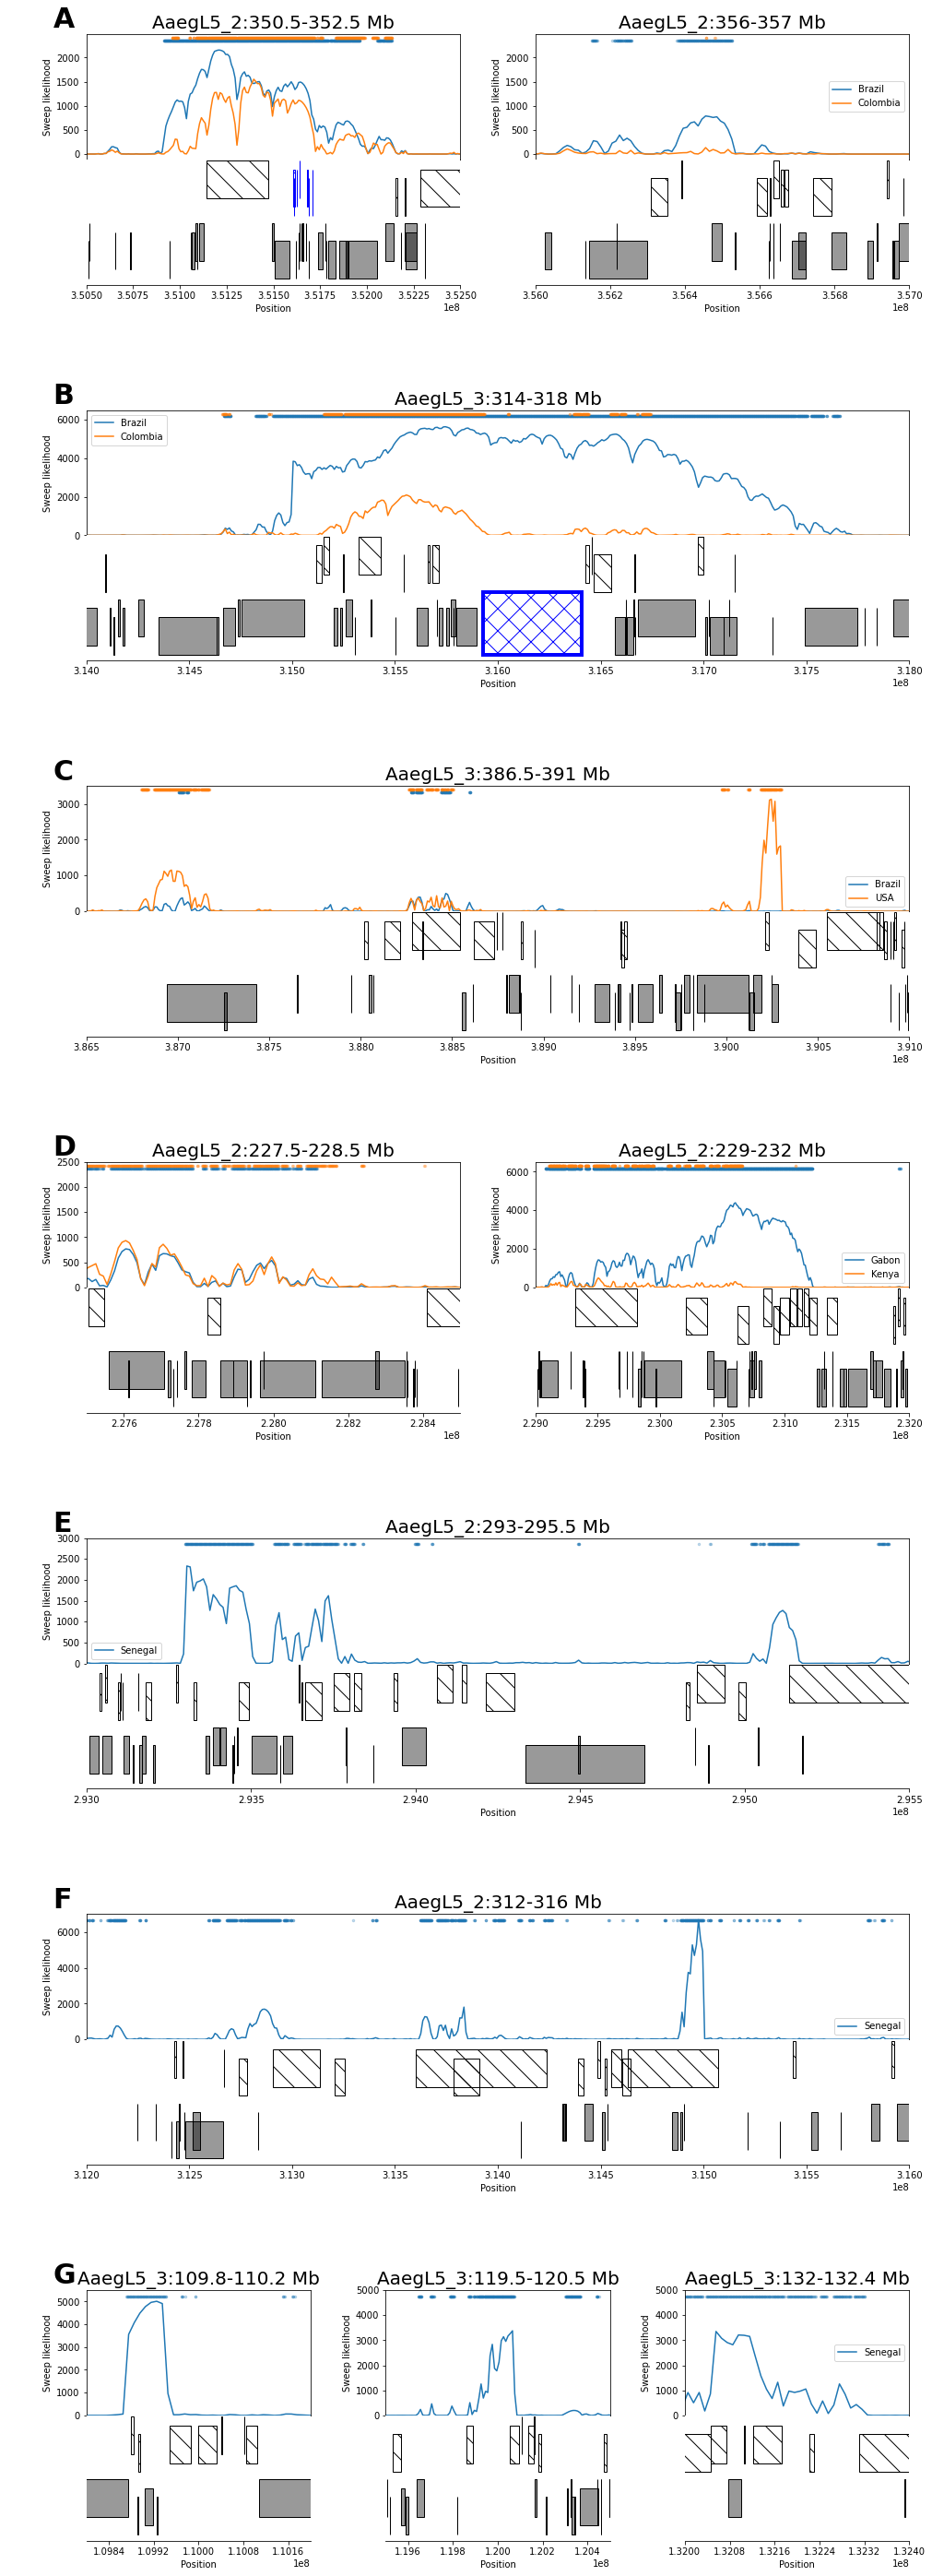

In [16]:
##set up the basic figure: 7 x 3, 
##with two subgridspec rows for each one chunk of the eight

fig = plt.figure(figsize=(16, 50), constrained_layout=True)
gs = GridSpec(nrows=20, ncols = 6, figure=fig, hspace=0, wspace=1)
    
#############################################
### SWEEP 1: AaegL5_2, ~ 350 Mb, Bra, Col ###
#############################################

ax0_0_0 = fig.add_subplot(gs[0, :3])
ax0_1_0 = fig.add_subplot(gs[1, :3], sharex=ax0_0_0)

ax0_0_1 = fig.add_subplot(gs[0, 3:])
ax0_1_1 = fig.add_subplot(gs[1, 3:], sharex=ax0_0_1)

ax0_2 = fig.add_subplot(gs[2, :])

ax0_2.set_visible(False)

for i, pop in enumerate(["Brazil", "Colombia"]):
        
    ##plot 10k windows
    out, windows, counts = average_sw_dict["10k_nonsliding"]["AaegL5_2"][pop]
            
    ax0_0_0.plot(np.mean(windows, axis=1), out, label=pop)

    ax0_0_0.set_xlim([350500000, 352500000])
        
    ax0_0_0.set_title("AaegL5_2:350.5-352.5 Mb", 
                         fontsize=20)
    
    ax0_0_1.plot(np.mean(windows, axis=1), out, label=pop)

    ax0_0_1.set_xlim([356000000, 357000000])
        
    ax0_0_1.set_title("AaegL5_2:356-357 Mb", 
                         fontsize=20)
    
##outliers
Bra_outlier_bool = outlier_bools["Brazil"]["AaegL5_2"]
Col_outlier_bool = outlier_bools["Colombia"]["AaegL5_2"]

trans_l = transforms.blended_transform_factory(ax0_0_0.transData, ax0_0_0.transAxes)

trans_r = transforms.blended_transform_factory(ax0_0_1.transData, ax0_0_1.transAxes)
    
ax0_0_0.plot(
    sweepfinder_in["Brazil"]["AaegL5_2"].loc[Bra_outlier_bool, "location"], 
    [0.95] * np.sum(Bra_outlier_bool), color=cmap(0), transform=trans_l, **marker_kwargs)

ax0_0_1.plot(
    sweepfinder_in["Brazil"]["AaegL5_2"].loc[Bra_outlier_bool, "location"],
    [0.95] * np.sum(Bra_outlier_bool), color=cmap(0), transform=trans_r, **marker_kwargs)

ax0_0_0.plot(
    sweepfinder_in["Colombia"]["AaegL5_2"].loc[Col_outlier_bool, "location"], 
    [0.97] * np.sum(Col_outlier_bool), color=cmap(1), transform=trans_l, **marker_kwargs)

ax0_0_1.plot(
    sweepfinder_in["Colombia"]["AaegL5_2"].loc[Col_outlier_bool, "location"], 
    [0.97] * np.sum(Col_outlier_bool), color=cmap(1), transform=trans_r, **marker_kwargs)

ax0_0_1.legend()

for ax in [ax0_0_0, ax0_0_1]:
            
    upper_bound = ax.get_ylim()[1]
    ax.set_ylim(top=upper_bound*1.1)
    ax.get_xaxis().set_visible(False)
    ax.set_ylabel("Sweep likelihood")
    
for ax in [ax0_1_0, ax0_1_1]:
    
    ax.get_yaxis().set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    ax.set_xlabel("Position")

##add genes

chunk = genes_2.loc[((genes_2["start"] > 300000000) & (genes_2["start"] < 400000000))]

for _, row in chunk.iterrows():

    gene_length = row["end"] - row["start"]
    
    if "glutathione transferase" in row["attributes"]:
        
            start = next(row_2_starts)
        
            rect = patches.Rectangle((row["start"], start), gene_length, 0.3, linewidth=1,
                                     edgecolor = colors.to_rgba("blue", 1), 
                                     facecolor = colors.to_rgba("white", 0),
                                     hatch = "xx")
            
            rect2 = deepcopy(rect)

    
    elif "protein_coding_gene" in row["type"] and not "unspecified product" in row["attributes"]:

            start = next(row_2_starts)
        
            rect = patches.Rectangle((row["start"], start), gene_length, 0.3, linewidth=1,
                                     edgecolor = colors.to_rgba("black", 1), 
                                     facecolor = colors.to_rgba("white", 0),
                                     hatch = "\\")
            
            rect2 = deepcopy(rect)

    else:

        start = next(row_1_starts)

        rect = patches.Rectangle((row["start"], start), gene_length, 0.3, linewidth=1,
                                 edgecolor = colors.to_rgba("black", 1), 
                                 facecolor = colors.to_rgba("black", 0.4))
    
        
        rect2 = deepcopy(rect)

    ax0_1_0.add_patch(rect)
    
    ax0_1_1.add_patch(rect2)
    

#############################################
### SWEEP 2: AaegL5_3, ~ 315 Mb, Bra, Col ###
#############################################

ax1_0 = fig.add_subplot(gs[3, :])
ax1_1 = fig.add_subplot(gs[4, :], sharex=ax1_0)
ax1_2 = fig.add_subplot(gs[5, :])

ax1_2.set_visible(False)

for i, pop in enumerate(["Brazil", "Colombia"]):
        
    ##plot 10k windows
    out, windows, counts = average_sw_dict["10k_nonsliding"]["AaegL5_3"][pop]
            
    ax1_0.plot(np.mean(windows, axis=1), out, label=pop)

    ax1_0.set_xlim([314000000, 318000000])
    
    ax1_0.set_ylim([0, 6500])
    
    ax1_0.set_title("AaegL5_3:314-318 Mb", 
                         fontsize=20)
    
ax1_0.legend(loc = "upper left")
ax1_0.set_ylabel("Sweep likelihood")
ax1_0.get_xaxis().set_visible(False)
    
ax1_1.get_yaxis().set_visible(False)
ax1_1.spines["left"].set_visible(False)
ax1_1.spines["right"].set_visible(False)
ax1_1.spines["top"].set_visible(False)
ax1_1.set_xlabel("Position")

trans = transforms.blended_transform_factory(ax1_0.transData, ax1_0.transAxes)
    
##show outliers
Bra_outlier_bool = outlier_bools["Brazil"]["AaegL5_3"]
Col_outlier_bool = outlier_bools["Colombia"]["AaegL5_3"]

ax1_0.plot(
    sweepfinder_in["Brazil"]["AaegL5_3"].loc[Bra_outlier_bool, "location"], 
    [0.95] * np.sum(Bra_outlier_bool), color=cmap(0), transform=trans, **marker_kwargs)

ax1_0.plot(
    sweepfinder_in["Colombia"]["AaegL5_3"].loc[Col_outlier_bool, "location"], 
    [0.97] * np.sum(Col_outlier_bool), color=cmap(1), transform=trans, **marker_kwargs)

##add the genes

chunk = genes_3.loc[((genes_3["start"] > 300000000) & (genes_3["start"] < 350000000))]

for _, row in chunk.iterrows():

    gene_length = row["end"] - row["start"]
    
    if "protein_coding_gene" in row["type"] and not "unspecified product" in row["attributes"]:
        
        start = next(row_2_starts)

        rect = patches.Rectangle((row["start"], start), gene_length, 0.3, linewidth=1,
                                             edgecolor = colors.to_rgba("black", 1), 
                                             facecolor = colors.to_rgba("white", 0),
                                             hatch = "\\")
    
    elif "AAEL023266" in row["attributes"]:

        rect = patches.Rectangle((row["start"], 0.05), gene_length, 0.5, linewidth=4,
                            edgecolor = "blue", fill = None, hatch = "x")            
    else:
        
        start = next(row_1_starts)

        rect = patches.Rectangle((row["start"], start), gene_length, 0.3, linewidth=1,
                                         edgecolor = colors.to_rgba("black", 1), 
                                         facecolor = colors.to_rgba("black", 0.4))

    ax1_1.add_patch(rect)
    
#############################################
### SWEEP 3: AaegL5_3, ~ 400 Mb, Bra, USA ###
#############################################

ax2_0 = fig.add_subplot(gs[6, :])
ax2_1 = fig.add_subplot(gs[7, :], sharex=ax2_0)

ax2_2 = fig.add_subplot(gs[8, :])
ax2_2.set_visible(False)

for i, pop in enumerate(["Brazil", "USA"]):
        
    ##plot 10k windows
    out, windows, counts = average_sw_dict["10k_nonsliding"]["AaegL5_3"][pop]
            
    ax2_0.plot(np.mean(windows, axis=1), out, label=pop)

    ax2_0.set_xlim([386500000, 391000000])
    
    ax2_0.set_ylim([0, 3500])
        
ax2_0.set_title("AaegL5_3:386.5-391 Mb", fontsize=20)
ax2_0.legend()

for ax in [ax2_0]:
    ax.set_ylabel("Sweep likelihood")
    ax.set_ylabel("Sweep likelihood")
    ax.get_xaxis().set_visible(False)
    
for ax in [ax2_1]:
    ax.get_yaxis().set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("Position")

##add outliers

Bra_outlier_bool = outlier_bools["Brazil"]["AaegL5_3"]
USA_outlier_bool = outlier_bools["USA"]["AaegL5_3"]

trans = transforms.blended_transform_factory(ax2_0.transData, ax2_0.transAxes)
    
##show outliers
ax2_0.plot(
    sweepfinder_in["Brazil"]["AaegL5_3"].loc[Bra_outlier_bool, "location"], 
    [0.95] * np.sum(Bra_outlier_bool), color=cmap(0), transform=trans, **marker_kwargs)

ax2_0.plot(
    sweepfinder_in["USA"]["AaegL5_3"].loc[USA_outlier_bool, "location"], 
    [0.97] * np.sum(USA_outlier_bool), color=cmap(1), transform=trans, **marker_kwargs)

##add the genes

chunk = genes_3.loc[((genes_3["start"] > 370000000) & (genes_3["start"] < 405000000))]

for _, row in chunk.iterrows():

    gene_length = row["end"] - row["start"]
    
    if "protein_coding_gene" in row["type"] and not "unspecified product" in row["attributes"]:
        
        start = next(row_2_starts)

        rect = patches.Rectangle((row["start"], start), gene_length, 0.3, linewidth=1,
                                             edgecolor = colors.to_rgba("black", 1), 
                                             facecolor = colors.to_rgba("white", 0),
                                             hatch = "\\")
                    
    else:

        start = next(row_1_starts)

        rect = patches.Rectangle((row["start"], start), gene_length, 0.3, linewidth=1,
                                         edgecolor = colors.to_rgba("black", 1), 
                                         facecolor = colors.to_rgba("black", 0.4))
        
    ax2_1.add_patch(rect)

#############################################
### SWEEP 4: AaegL5_2, ~ 225 Mb, Gab, Ken ###
#############################################

ax3_0_0 = fig.add_subplot(gs[9, :3])
ax3_1_0 = fig.add_subplot(gs[10, :3], sharex=ax3_0_0)

ax3_0_1 = fig.add_subplot(gs[9, 3:])
ax3_1_1 = fig.add_subplot(gs[10, 3:], sharex=ax3_0_1)

ax3_2 = fig.add_subplot(gs[11, :])
ax3_2.set_visible(False)

for i, pop in enumerate(["Gabon", "Kenya"]):
        
    ##plot 10k windows
    out, windows, counts = average_sw_dict["10k_nonsliding"]["AaegL5_2"][pop]
            
    ax3_0_0.plot(np.mean(windows, axis=1), out, label=pop)

    ax3_0_0.set_xlim([227500000, 228500000])
    
    ax3_0_0.set_ylim([0, 2500])
    
    ax3_0_1.plot(np.mean(windows, axis=1), out, label=pop)

    ax3_0_1.set_xlim([229000000, 232000000])
    
    ax3_0_1.set_ylim([0, 6500])
    
ax3_0_0.set_title("AaegL5_2:227.5-228.5 Mb", fontsize=20)
ax3_0_1.set_title("AaegL5_2:229-232 Mb", fontsize=20)
ax3_0_1.legend()

for ax in [ax3_0_0, ax3_0_1]:
    ax.set_ylabel("Sweep likelihood")
    ax.set_ylabel("Sweep likelihood")
    ax.get_xaxis().set_visible(False)
    
for ax in [ax3_1_0, ax3_1_1]:
    ax.get_yaxis().set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("Position")

##add outliers

Gab_outlier_bool = outlier_bools["Gabon"]["AaegL5_2"]
Ken_outlier_bool = outlier_bools["Kenya"]["AaegL5_2"]

trans_l = transforms.blended_transform_factory(ax3_0_0.transData, ax3_0_0.transAxes)

trans_r = transforms.blended_transform_factory(ax3_0_1.transData, ax3_0_1.transAxes)
    
##show outliers
ax3_0_0.plot(
    sweepfinder_in["Gabon"]["AaegL5_2"].loc[Gab_outlier_bool, "location"], 
    [0.95] * np.sum(Gab_outlier_bool), color=cmap(0), transform=trans_l, **marker_kwargs)

ax3_0_0.plot(
    sweepfinder_in["Kenya"]["AaegL5_2"].loc[Ken_outlier_bool, "location"], 
    [0.97] * np.sum(Ken_outlier_bool), color=cmap(1), transform=trans_l, **marker_kwargs)

ax3_0_1.plot(
    sweepfinder_in["Gabon"]["AaegL5_2"].loc[Gab_outlier_bool, "location"], 
    [0.95] * np.sum(Gab_outlier_bool), color=cmap(0), transform=trans_r, **marker_kwargs)

ax3_0_1.plot(
    sweepfinder_in["Kenya"]["AaegL5_2"].loc[Ken_outlier_bool, "location"], 
    [0.97] * np.sum(Ken_outlier_bool), color=cmap(1), transform=trans_r, **marker_kwargs)

##add the genes

chunk = genes_2.loc[((genes_2["start"] > 200000000) & (genes_2["start"] < 250000000))]

for _, row in chunk.iterrows():

    gene_length = row["end"] - row["start"]
    
    if "protein_coding_gene" in row["type"] and not "unspecified product" in row["attributes"]:
        
        start = next(row_2_starts)

        rect = patches.Rectangle((row["start"], start), gene_length, 0.3, linewidth=1,
                                             edgecolor = colors.to_rgba("black", 1), 
                                             facecolor = colors.to_rgba("white", 0),
                                             hatch = "\\")
        
        rect2 = deepcopy(rect)
            
    else:

        start = next(row_1_starts)

        rect = patches.Rectangle((row["start"], start), gene_length, 0.3, linewidth=1,
                                         edgecolor = colors.to_rgba("black", 1), 
                                         facecolor = colors.to_rgba("black", 0.4))
        
        rect2 = deepcopy(rect)

    ax3_1_0.add_patch(rect)
    
    ax3_1_1.add_patch(rect2)

########################################
### SWEEP 5: AaegL5_2, ~ 290 Mb, Sen ###
########################################

ax4_0 = fig.add_subplot(gs[12, :])
ax4_1 = fig.add_subplot(gs[13, :], sharex=ax4_0)
ax4_2 = fig.add_subplot(gs[14, :])

ax4_2.set_visible(False)

pop = "Senegal"
        
##plot 10k windows for chrom 2 sweep
out, windows, counts = average_sw_dict["10k_nonsliding"]["AaegL5_2"][pop]

ax4_0.plot(np.mean(windows, axis=1), out, label=pop)

ax4_0.set_xlim([293000000, 295500000])
ax4_0.set_ylim([0, 3000])
ax4_0.set_ylabel("Sweep likelihood")
ax4_0.set_title("AaegL5_2:293-295.5 Mb", fontsize=20)
ax4_0.legend()
ax4_0.get_xaxis().set_visible(False)
    
ax4_1.get_yaxis().set_visible(False)
ax4_1.spines["left"].set_visible(False)
ax4_1.spines["right"].set_visible(False)
ax4_1.spines["top"].set_visible(False)
ax4_1.set_xlabel("Position")

##add outliers

Sen_outlier_bool = outlier_bools["Senegal"]["AaegL5_2"]

trans = transforms.blended_transform_factory(ax4_0.transData, ax4_0.transAxes)
    
##show outliers
ax4_0.plot(
    sweepfinder_in["Senegal"]["AaegL5_2"].loc[Sen_outlier_bool, "location"], 
    [0.95] * np.sum(Sen_outlier_bool), color=cmap(0), transform=trans, **marker_kwargs)

##add the genes

chunk = genes_2.loc[((genes_2["start"] > 270000000) & (genes_2["start"] < 320000000))]

for _, row in chunk.iterrows():

    gene_length = row["end"] - row["start"]
    
    if "protein_coding_gene" in row["type"] and "unspecified product" in row["attributes"]:
        
        start = next(row_2_starts)

        rect = patches.Rectangle((row["start"], start), gene_length, 0.3, linewidth=1,
                                             edgecolor = colors.to_rgba("black", 1), 
                                             facecolor = colors.to_rgba("white", 0),
                                             hatch = "\\")

    else:

        start = next(row_1_starts)

        rect = patches.Rectangle((row["start"], start), gene_length, 0.3, linewidth=1,
                                         edgecolor = colors.to_rgba("black", 1), 
                                         facecolor = colors.to_rgba("black", 0.4))

    ax4_1.add_patch(rect)

    
########################################
### SWEEP 6: AaegL5_2, ~ 315 Mb, Sen ###
########################################

ax5_0 = fig.add_subplot(gs[15, :])
ax5_1 = fig.add_subplot(gs[16, :], sharex=ax5_0)
ax5_2 = fig.add_subplot(gs[17, :])

ax5_2.set_visible(False)

pop = "Senegal"
        
##plot 10k windows for chrom 2 sweep
out, windows, counts = average_sw_dict["10k_nonsliding"]["AaegL5_2"][pop]

ax5_0.plot(np.mean(windows, axis=1), out, label=pop)

ax5_0.set_xlim([312000000, 316000000])
ax5_0.set_ylim([0, 7000])
ax5_0.set_ylabel("Sweep likelihood")
ax5_0.set_title("AaegL5_2:312-316 Mb", fontsize=20)
ax5_0.legend()
ax5_0.get_xaxis().set_visible(False)
    
ax5_1.get_yaxis().set_visible(False)
ax5_1.spines["left"].set_visible(False)
ax5_1.spines["right"].set_visible(False)
ax5_1.spines["top"].set_visible(False)
ax5_1.set_xlabel("Position")

##add outliers

Sen_outlier_bool = outlier_bools["Senegal"]["AaegL5_2"]

trans = transforms.blended_transform_factory(ax5_0.transData, ax5_0.transAxes)
    
##show outliers
ax5_0.plot(
    sweepfinder_in["Senegal"]["AaegL5_2"].loc[Sen_outlier_bool, "location"], 
    [0.95] * np.sum(Sen_outlier_bool), color=cmap(0), transform=trans, **marker_kwargs)

##add the genes

chunk = genes_2.loc[((genes_2["start"] > 290000000) & (genes_2["start"] < 340000000))]

for _, row in chunk.iterrows():

    gene_length = row["end"] - row["start"]
    
    if "protein_coding_gene" in row["type"] and "unspecified product" in row["attributes"]:
        
        start = next(row_2_starts)

        rect = patches.Rectangle((row["start"], start), gene_length, 0.3, linewidth=1,
                                             edgecolor = colors.to_rgba("black", 1), 
                                             facecolor = colors.to_rgba("white", 0),
                                             hatch = "\\")

    else:

        start = next(row_1_starts)

        rect = patches.Rectangle((row["start"], start), gene_length, 0.3, linewidth=1,
                                         edgecolor = colors.to_rgba("black", 1), 
                                         facecolor = colors.to_rgba("black", 0.4))

    ax5_1.add_patch(rect)

############################################
### SWEEP 7: AaegL5_3, ~ 100-140 Mb, Sen ###
############################################

ax6_0_0 = fig.add_subplot(gs[18, :2])
ax6_1_0 = fig.add_subplot(gs[19, :2], sharex=ax6_0_0)

ax6_0_1 = fig.add_subplot(gs[18, 2:4])
ax6_1_1 = fig.add_subplot(gs[19, 2:4], sharex=ax6_0_1)

ax6_0_2 = fig.add_subplot(gs[18, 4:])
ax6_1_2 = fig.add_subplot(gs[19, 4:], sharex=ax6_0_2)

pop = "Senegal"
        
##plot 10k windows for each of the three spikes
out, windows, counts = average_sw_dict["10k_nonsliding"]["AaegL5_3"][pop]

ax6_0_0.plot(np.mean(windows, axis=1), out, label=pop)
ax6_0_0.set_xlim([109800000, 110200000])
ax6_0_0.set_ylim([0, 5500])
ax6_0_0.set_title("AaegL5_3:109.8-110.2 Mb", fontsize=20)
ax6_0_0.xaxis.set_major_locator(plt.MaxNLocator(6))

ax6_0_1.plot(np.mean(windows, axis=1), out, label=pop)
ax6_0_1.set_xlim([119500000, 120500000])
ax6_0_1.set_ylim([0, 5000])
ax6_0_1.set_title("AaegL5_3:119.5-120.5 Mb", fontsize=20)

ax6_0_2.plot(np.mean(windows, axis=1), out, label=pop)
ax6_0_2.set_xlim([132000000, 132400000])
ax6_0_2.set_ylim([0, 5000])
ax6_0_2.set_title("AaegL5_3:132-132.4 Mb", fontsize=20)
ax6_0_2.legend()
ax6_0_2.xaxis.set_major_locator(plt.MaxNLocator(6))
    
for ax in [ax6_0_0, ax6_0_1, ax6_0_2]:
    ax.set_ylabel("Sweep likelihood")
    ax.get_xaxis().set_visible(False)
    
for ax in [ax6_1_0, ax6_1_1, ax6_1_2]:
    ax.get_yaxis().set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("Position")
    
##add outliers

Sen_outlier_bool = outlier_bools["Senegal"]["AaegL5_3"]

trans_l = transforms.blended_transform_factory(ax6_0_0.transData, ax6_0_0.transAxes)

trans_c = transforms.blended_transform_factory(ax6_0_1.transData, ax6_0_1.transAxes)

trans_r = transforms.blended_transform_factory(ax6_0_2.transData, ax6_0_2.transAxes)
    
##show outliers
ax6_0_0.plot(
    sweepfinder_in["Senegal"]["AaegL5_3"].loc[Sen_outlier_bool, "location"], 
    [0.95] * np.sum(Sen_outlier_bool), color=cmap(0), transform=trans_l, **marker_kwargs)

ax6_0_1.plot(
    sweepfinder_in["Senegal"]["AaegL5_3"].loc[Sen_outlier_bool, "location"],
    [0.95] * np.sum(Sen_outlier_bool), color=cmap(0), transform=trans_c, **marker_kwargs)

ax6_0_2.plot(
    sweepfinder_in["Senegal"]["AaegL5_3"].loc[Sen_outlier_bool, "location"], 
    [0.95] * np.sum(Sen_outlier_bool), color=cmap(0), transform=trans_r, **marker_kwargs)

##add the genes

chunk = genes_3.loc[((genes_3["start"] > 80000000) & (genes_3["start"] < 150000000))]

for _, row in chunk.iterrows():

    gene_length = row["end"] - row["start"]
    
    if "protein_coding_gene" in row["type"] and "unspecified product" in row["attributes"]:
        
        start = next(row_2_starts)

        rect = patches.Rectangle((row["start"], start), gene_length, 0.3, linewidth=1,
                                             edgecolor = colors.to_rgba("black", 1), 
                                             facecolor = colors.to_rgba("white", 0),
                                             hatch = "\\")
        
        rect2, rect3 = deepcopy(rect), deepcopy(rect)

    else:

        start = next(row_1_starts)

        rect = patches.Rectangle((row["start"], start), gene_length, 0.3, linewidth=1,
                                         edgecolor = colors.to_rgba("black", 1), 
                                         facecolor = colors.to_rgba("black", 0.4))
        
        rect2, rect3 = deepcopy(rect), deepcopy(rect)
        
    ax6_1_0.add_patch(rect)
    ax6_1_1.add_patch(rect2)
    ax6_1_2.add_patch(rect3)

##ADD LABELS

for label, ax in zip(["A", "B", "C", "D", "E", "F", "G"],
                     [ax0_0_0, ax1_0, ax2_0, ax3_0_0, 
                      ax4_0, ax5_0, ax6_0_0]):

    ax.annotate(label, (0.05,1.05), xycoords = ("figure fraction",
                                               "axes fraction"), 
                size=30, weight="bold")

#plt.savefig(outString, bbox_inches="tight")

##### identify the genes in these regions

In [17]:
def return_genes(genes, chrom, start, end):
    
    """Return all genes in a pandas dataframe rendering of a gff gene ontology file,
    that overlap a given range on a specific chromosome."""
    
    chunk = genes.loc[genes["seqid"] == chrom]
    
    overlapped = \
    (((chunk["start"] <= start) & (chunk["end"] >= start) & (chunk["end"] <= end)) |\
     ((chunk["start"] >= start) & (chunk["start"] <= end) & (chunk["end"] >= start) &\
      (chunk["end"] <= end)) |\
     ((chunk["start"] >= start) & (chunk["start"] <= end) & (chunk["end"] >= end)) |\
     ((chunk["start"] <= start) & (chunk["end"] >= end)))
    
    return chunk[overlapped]

In [18]:
overlapped_list = []

##### sweep a1

In [19]:
left, right = 351000000, 352000000

In [20]:
overlapped = return_genes(genes_2, "AaegL5_2", left, right)

overlapped["countries"] = "Brazil,Colombia"

overlapped["sweep"] = "a1"

overlapped.sort_values("start", inplace=True)

overlapped.head()

,seqid,source,type,start,end,score,strand,phase,attributes,name,countries,sweep
336401,AaegL5_2,VEuPathDB,protein_coding_gene,351058667,351059884,.,-,.,ID=AAEL026371;description=unspecified product,AAEL026371,"Brazil,Colombia",a1
92930,AaegL5_2,VEuPathDB,protein_coding_gene,351064034,351078244,.,+,.,ID=AAEL014534;description=unspecified product,AAEL014534,"Brazil,Colombia",a1
186739,AaegL5_2,VEuPathDB,protein_coding_gene,351082730,351094669,.,-,.,ID=AAEL014533;description=unspecified product,AAEL014533,"Brazil,Colombia",a1
264931,AaegL5_2,VEuPathDB,ncRNA_gene,351094787,351095795,.,+,.,ID=AAEL024596;description=unspecified product,AAEL024596,"Brazil,Colombia",a1
192099,AaegL5_2,VEuPathDB,protein_coding_gene,351104592,351129820,.,+,.,ID=AAEL013467;description=unspecified product,AAEL013467,"Brazil,Colombia",a1


In [21]:
overlapped_list.append(overlapped)

##### sweep a2

In [22]:
left, right = 356200000, 356600000

In [23]:
overlapped = return_genes(genes_2, "AaegL5_2", left, right)

overlapped["countries"] = "Brazil,Colombia"

overlapped["sweep"] = "a2"

overlapped.sort_values("start", inplace=True)

overlapped.head()

,seqid,source,type,start,end,score,strand,phase,attributes,name,countries,sweep
282984,AaegL5_2,VEuPathDB,protein_coding_gene,356142855,356299631,.,+,.,ID=AAEL027210;description=unspecified product,AAEL027210,"Brazil,Colombia",a2
55373,AaegL5_2,VEuPathDB,ncRNA_gene,356218055,356218126,.,+,.,ID=AAEL016796;description=unspecified product,AAEL016796,"Brazil,Colombia",a2
55374,AaegL5_2,VEuPathDB,tRNA,356218055,356218126,.,+,.,ID=AAEL016796-RA;Parent=AAEL016796;description...,AAEL016796-RA,"Brazil,Colombia",a2
53614,AaegL5_2,VEuPathDB,protein_coding_gene,356309156,356352442,.,-,.,ID=AAEL002055;description=neuroendocrine prote...,AAEL002055,"Brazil,Colombia",a2
317846,AaegL5_2,VEuPathDB,protein_coding_gene,356390672,356392588,.,+,.,ID=AAEL002085;Name=CYP4H31;description=cytochr...,AAEL002085,"Brazil,Colombia",a2


In [24]:
overlapped_list.append(overlapped)

##### sweep b

In [25]:
left, right = 314500000, 317500000

In [26]:
overlapped = return_genes(genes_3, "AaegL5_3", left, right)

overlapped["countries"] = "Brazil,Colombia"

overlapped["sweep"] = "b"

overlapped.sort_values("start", inplace=True)

overlapped.head()

,seqid,source,type,start,end,score,strand,phase,attributes,name,countries,sweep
280195,AaegL5_3,VEuPathDB,ncRNA_gene,314349160,314643070,.,+,.,ID=AAEL023993;description=unspecified product,AAEL023993,"Brazil,Colombia",b
207845,AaegL5_3,VEuPathDB,ncRNA_gene,314634153,314634989,.,-,.,ID=AAEL028196;description=unspecified product,AAEL028196,"Brazil,Colombia",b
206132,AaegL5_3,VEuPathDB,protein_coding_gene,314664216,314723694,.,+,.,ID=AAEL024841;description=unspecified product,AAEL024841,"Brazil,Colombia",b
114158,AaegL5_3,VEuPathDB,protein_coding_gene,314735653,314744258,.,+,.,ID=AAEL006025;description=unspecified product,AAEL006025,"Brazil,Colombia",b
314212,AaegL5_3,VEuPathDB,protein_coding_gene,314752556,315059781,.,+,.,ID=AAEL006035;description=unspecified product,AAEL006035,"Brazil,Colombia",b


In [27]:
overlapped_list.append(overlapped)

##### sweep c

In [28]:
left, right = 386500000, 391000000

In [29]:
overlapped = return_genes(genes_3, "AaegL5_3", left, right)

overlapped["countries"] = "USA"

overlapped["sweep"] = "c"

overlapped.sort_values("start", inplace=True)

overlapped.head()

,seqid,source,type,start,end,score,strand,phase,attributes,name,countries,sweep
110059,AaegL5_3,VEuPathDB,protein_coding_gene,386938208,387429583,.,-,.,ID=AAEL019407;description=unspecified product,AAEL019407,USA,c
287338,AaegL5_3,VEuPathDB,ncRNA_gene,387252499,387267242,.,-,.,ID=AAEL020160;description=unspecified product,AAEL020160,USA,c
324693,AaegL5_3,VEuPathDB,ncRNA_gene,387653711,387654928,.,+,.,ID=AAEL026477;description=unspecified product,AAEL026477,USA,c
152685,AaegL5_3,VEuPathDB,ncRNA_gene,387947287,387948264,.,-,.,ID=AAEL026223;description=unspecified product,AAEL026223,USA,c
252865,AaegL5_3,VEuPathDB,protein_coding_gene,388019073,388039644,.,-,.,ID=AAEL000559;description=glycosyl transferase,AAEL000559,USA,c


In [30]:
overlapped_list.append(overlapped)

##### sweep d1

In [31]:
left, right = 227500000, 228200000

In [32]:
overlapped = return_genes(genes_2, "AaegL5_2", left, right)

overlapped["countries"] = "Gabon, Kenya"

overlapped["sweep"] = "d1"

overlapped.sort_values("start", inplace=True)

overlapped.head()

,seqid,source,type,start,end,score,strand,phase,attributes,name,countries,sweep
214855,AaegL5_2,VEuPathDB,protein_coding_gene,227505152,227548515,.,-,.,ID=AAEL000227;Name=SCRB8;description=Class B S...,AAEL000227,"Gabon, Kenya",d1
204729,AaegL5_2,VEuPathDB,protein_coding_gene,227561150,227708534,.,-,.,ID=AAEL024346;description=unspecified product,AAEL024346,"Gabon, Kenya",d1
57965,AaegL5_2,VEuPathDB,ncRNA_gene,227612950,227615235,.,-,.,ID=AAEL025747;description=unspecified product,AAEL025747,"Gabon, Kenya",d1
219905,AaegL5_2,VEuPathDB,protein_coding_gene,227717692,227724446,.,+,.,ID=AAEL000245;description=unspecified product,AAEL000245,"Gabon, Kenya",d1
205016,AaegL5_2,VEuPathDB,ncRNA_gene,227732981,227733383,.,-,.,ID=AAEL027144;description=unspecified product,AAEL027144,"Gabon, Kenya",d1


In [33]:
overlapped_list.append(overlapped)

##### sweep d2

In [34]:
left, right = 229500000, 231250000

In [35]:
overlapped = return_genes(genes_2, "AaegL5_2", left, right)

overlapped["countries"] = "Gabon,Kenya"

overlapped["sweep"] = "d2"

overlapped.sort_values("start", inplace=True)

overlapped.head()

,seqid,source,type,start,end,score,strand,phase,attributes,name,countries,sweep
380169,AaegL5_2,VEuPathDB,protein_coding_gene,229323293,229817525,.,+,.,ID=AAEL011222;Name=SCRB5;description=Class B S...,AAEL011222,"Gabon,Kenya",d2
166241,AaegL5_2,VEuPathDB,ncRNA_gene,229668851,229669392,.,-,.,ID=AAEL024290;description=unspecified product,AAEL024290,"Gabon,Kenya",d2
186060,AaegL5_2,VEuPathDB,ncRNA_gene,229676474,229677165,.,+,.,ID=AAEL022504;description=unspecified product,AAEL022504,"Gabon,Kenya",d2
328493,AaegL5_2,VEuPathDB,ncRNA_gene,229677655,229678438,.,-,.,ID=AAEL024758;description=unspecified product,AAEL024758,"Gabon,Kenya",d2
53996,AaegL5_2,VEuPathDB,ncRNA_gene,229736790,229737388,.,-,.,ID=AAEL026090;description=unspecified product,AAEL026090,"Gabon,Kenya",d2


In [36]:
overlapped_list.append(overlapped)

##### sweep e

In [37]:
left, right = 293000000, 295500000

In [38]:
overlapped = return_genes(genes_2, "AaegL5_2", left, right)

overlapped["countries"] = "Senegal"

overlapped["sweep"] = "e"

overlapped.sort_values("start", inplace=True)

overlapped.head()

,seqid,source,type,start,end,score,strand,phase,attributes,name,countries,sweep
303323,AaegL5_2,VEuPathDB,protein_coding_gene,293010233,293037541,.,-,.,ID=AAEL004293;description=Transformer 2 isofor...,AAEL004293,Senegal,e
319126,AaegL5_2,VEuPathDB,protein_coding_gene,293040717,293045859,.,+,.,ID=AAEL020698;description=unspecified product,AAEL020698,Senegal,e
127216,AaegL5_2,VEuPathDB,protein_coding_gene,293048306,293077778,.,+,.,ID=AAEL004294;description=dihydrolipoamide ace...,AAEL004294,Senegal,e
43704,AaegL5_2,VEuPathDB,protein_coding_gene,293058207,293062494,.,-,.,ID=AAEL026605;description=unspecified product,AAEL026605,Senegal,e
230494,AaegL5_2,VEuPathDB,protein_coding_gene,293095143,293102403,.,+,.,ID=AAEL004301;description=unspecified product,AAEL004301,Senegal,e


In [39]:
overlapped_list.append(overlapped)

##### sweep f

In [40]:
left, right = 312000000, 315500000

In [41]:
overlapped = return_genes(genes_2, "AaegL5_2", left, right)

overlapped["countries"] = "Senegal"

overlapped["sweep"] = "f"

overlapped.sort_values("start", inplace=True)

overlapped.head()

,seqid,source,type,start,end,score,strand,phase,attributes,name,countries,sweep
93564,AaegL5_2,VEuPathDB,ncRNA_gene,312248371,312249617,.,+,.,ID=AAEL021059;description=unspecified product,AAEL021059,Senegal,f
390420,AaegL5_2,VEuPathDB,ncRNA_gene,312339281,312339713,.,+,.,ID=AAEL026963;description=unspecified product,AAEL026963,Senegal,f
14825,AaegL5_2,VEuPathDB,protein_coding_gene,312412112,312415772,.,-,.,ID=AAEL007275;description=aldo-keto reductase,AAEL007275,Senegal,f
365934,AaegL5_2,VEuPathDB,protein_coding_gene,312427970,312436279,.,+,.,ID=AAEL007276;description=unspecified product,AAEL007276,Senegal,f
247197,AaegL5_2,VEuPathDB,protein_coding_gene,312437583,312450955,.,-,.,ID=AAEL007273;description=peptidyl-prolyl cis-...,AAEL007273,Senegal,f


In [42]:
overlapped_list.append(overlapped)

##### sweep g1

In [43]:
left, right = 109800000, 110100000

In [44]:
overlapped = return_genes(genes_3, "AaegL5_3", left, right)

overlapped["countries"] = "Senegal"

overlapped["sweep"] = "g1"

overlapped.sort_values("start", inplace=True)

overlapped.head()

,seqid,source,type,start,end,score,strand,phase,attributes,name,countries,sweep
209694,AaegL5_3,VEuPathDB,protein_coding_gene,109792946,109875400,.,+,.,ID=AAEL004480;description=cell division cycle ...,AAEL004480,Senegal,g1
207771,AaegL5_3,VEuPathDB,protein_coding_gene,109880327,109884552,.,-,.,ID=AAEL023070;description=unspecified product,AAEL023070,Senegal,g1
291434,AaegL5_3,VEuPathDB,protein_coding_gene,109891270,109893078,.,+,.,ID=AAEL025887;description=Zinc finger CCCH-typ...,AAEL025887,Senegal,g1
56457,AaegL5_3,VEuPathDB,protein_coding_gene,109893339,109895369,.,-,.,ID=AAEL026766;description=unspecified product,AAEL026766,Senegal,g1
271150,AaegL5_3,VEuPathDB,protein_coding_gene,109904658,109918308,.,+,.,ID=AAEL027029;description=Cell division contro...,AAEL027029,Senegal,g1


In [45]:
overlapped_list.append(overlapped)

##### sweep g2

In [46]:
left, right = 119700000, 120200000

In [47]:
overlapped = return_genes(genes_3, "AaegL5_3", left, right)

overlapped["countries"] = "Senegal"

overlapped["sweep"] = "g2"

overlapped.sort_values("start", inplace=True)

overlapped.head()

,seqid,source,type,start,end,score,strand,phase,attributes,name,countries,sweep
352220,AaegL5_3,VEuPathDB,protein_coding_gene,119817255,119819278,.,+,.,ID=AAEL000801;description=metalloproteinase%2C...,AAEL000801,Senegal,g2
195599,AaegL5_3,VEuPathDB,protein_coding_gene,119860800,119890243,.,-,.,ID=AAEL018135;description=unspecified product,AAEL018135,Senegal,g2
131050,AaegL5_3,VEuPathDB,protein_coding_gene,120052795,120092569,.,+,.,ID=AAEL025454;description=unspecified product,AAEL025454,Senegal,g2
281189,AaegL5_3,VEuPathDB,protein_coding_gene,120106834,120108208,.,+,.,ID=AAEL024981;description=unspecified product,AAEL024981,Senegal,g2
279281,AaegL5_3,VEuPathDB,protein_coding_gene,120134514,120160773,.,-,.,ID=AAEL000815;description=unspecified product,AAEL000815,Senegal,g2


In [48]:
overlapped_list.append(overlapped)

##### sweep g3

In [49]:
left, right = 132000000, 132250000

In [50]:
overlapped = return_genes(genes_3, "AaegL5_3", left, right)

overlapped["countries"] = "Senegal"

overlapped["sweep"] = "g3"

overlapped.sort_values("start", inplace=True)

overlapped.head()

,seqid,source,type,start,end,score,strand,phase,attributes,name,countries,sweep
70811,AaegL5_3,VEuPathDB,protein_coding_gene,131992337,132046298,.,+,.,ID=AAEL028079;description=unspecified product,AAEL028079,Senegal,g3
245683,AaegL5_3,VEuPathDB,protein_coding_gene,132046237,132073384,.,-,.,ID=AAEL008042;description=unspecified product,AAEL008042,Senegal,g3
154574,AaegL5_3,VEuPathDB,protein_coding_gene,132076670,132100521,.,+,.,ID=AAEL008041;description=bleomycin hydrolase,AAEL008041,Senegal,g3
313861,AaegL5_3,VEuPathDB,protein_coding_gene,132105180,132106496,.,-,.,ID=AAEL008038;description=unspecified product,AAEL008038,Senegal,g3
18030,AaegL5_3,VEuPathDB,protein_coding_gene,132121152,132172115,.,-,.,ID=AAEL008815;description=unspecified product,AAEL008815,Senegal,g3


In [51]:
overlapped_list.append(overlapped)

##### compile

In [52]:
len(overlapped_list)

11

In [53]:
overlapped_df = pd.concat(overlapped_list)

overlapped_df.shape

(319, 12)